<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
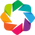

In [83]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from igraph import *

import bokeh
import json

# Import and start a Spark session.
from pyspark.sql import *
spark = SparkSession.builder.getOrCreate()
import dateutil.parser
import warnings; warnings.simplefilter('ignore')

import holoviews as hv
import networkx as nx
from holoviews.operation.datashader import datashade, bundle_graph

hv.extension('bokeh');

%opts Graph [width=400 height=400]

plt.rcParams['figure.figsize'] = [12, 8]

## Using pagerank to find important users

As always the first step is to load our data. Here, it is not usefull to load the dataset with spark are we are directly converting it to pandas. However, we are still doing it as it will ease the reproductibility of our analysis on hashtags having more tweets: we just have to sample the pyspark dataframe  before converting it to pandas.

In [2]:
tweets = spark.read.json('balancetonporc.json')

In [58]:
tweets_pd = tweets.toPandas()

In [62]:
tweets_pd['created_at'] = pd.to_datetime(tweets_pd['created_at'], unit="ms")
tweets_pd.head()

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,tags,time,timezone,tweet,urls,user_id,username,video_thumb,video_url,created_att
0,1071507278875033600,2018-12-08 20:50:17,2018-12-08,,,0,[#balancetonporc],1071507278875033600,0,0,...,[],21:50:17,CET,Un livreur de pizza qui demande clairement des...,[],777095708692324353,hllelea,,,2018-12-08 20:50:17
1,1071495065514721280,2018-12-08 20:01:45,2018-12-08,,,0,[#balancetonporc],1071495065514721280,0,0,...,[],21:01:45,CET,J'ai ajouté une vidéo à une playlist @YouTube ...,[http://youtu.be/QYAYnGu_iaw?a],830093777591234560,chouchoue_,,,2018-12-08 20:01:45
2,1071483541286993920,2018-12-08 19:15:58,2018-12-08,,,0,[#balancetonporc],1071483541286993920,0,0,...,[],20:15:58,CET,#balancetonporc https://www.sudouest.fr/2018/...,[https://www.sudouest.fr/2018/09/05/il-photogr...,882276333291786240,sweetieoparadis,,,2018-12-08 19:15:58
3,1071481275528167425,2018-12-08 19:06:57,2018-12-08,,,0,[#balancetonporc],1071481275528167425,0,0,...,[],20:06:57,CET,Salut la twitosphère #balancetonporc,[],1042521930849570816,duhippolyte,,,2018-12-08 19:06:57
4,1071468524571451392,2018-12-08 18:16:17,2018-12-08,,,0,"[#balancetonporc, #balanceta2000]",1071468524571451392,0,0,...,[],19:16:17,CET,Après #balancetonporc il y a #balanceta2000 @L...,[],1065703994,alex____torres_,,,2018-12-08 18:16:17


Our goal is to find which users had the most impact on the tweets having a given hashtag. If we think about it, if some tweets of a user are highly retweeted, then he must have had some influence, because he could have made an other user tweet about the hashtag. Google used the same thought when they created the pagerank algorithm to find pertinent webpages: the more links are pointing toward a ressource $X$, the most important $X$ might be.

Henceforth, we have decided to adapt pagerank to the problem of finding the users having the most impact. We model a graph as following:
- Every user $a$ having tweeted about the hashtag is a node
- Their is an edge from $a$ to $b$ if and only if $a$ retweeted $b$.
We then compute pagerank other this graph.

### Computing pagerank

We first start by building an `igraph` Graph. Unfortunately `twint` doesn't allow us to know if a tweet is a retweet. However, after playing with it and examining carefully the structure of the page it scrapped, we discovered that if a tweet was indeed a retweet, then the url of the retweeted tweet would be put inside the field 'quote_url'.

In [4]:
def extract_username_from_link(link):
    """ Extract the username from a twitter link (https://twitter.com/USERNAME/...)"""
    return link.split('/')[3]

In [5]:
def build_graph():
    graph = Graph(directed = True)
    edges = pd.DataFrame()
    # first we filter on the user having a non empty quote_url
    retweets = tweets_pd[tweets_pd.is_quote_status == 1]
    # we retrieve the username from the quoted url
    edges['to'] = retweets.quote_url.map(extract_username_from_link)
    edges['from'] = retweets.username
    # we build the graph
    for i, row in edges.iterrows():
        if row['from'] != row['to']:
            graph.add_vertex(row['from'])
            graph.add_vertex(row['to'])
            graph.add_edge(row['from'], row['to'])
    return graph

In [6]:
graph = build_graph()

We can now compute pagerank and add the pagerank rank as attribute to each vertex:

In [7]:
pagerank = graph.pagerank()

In [8]:
graph.vs['pagerank'] = pagerank

Below we ranked the nodes indices according their pagerank rank.

In [9]:
indices = list(range(graph.vcount()))
indices.sort(key=graph.vs['pagerank'].__getitem__, reverse=True)

### Analyzing the results

Who are the most impactfull users?

In [28]:
ranked_users = pd.DataFrame()
ranked_users['name'] = [graph.vs['name'][i] for i in indices]
ranked_users['pagerank'] = [graph.vs['pagerank'][i] for i in indices]

In [31]:
top_20_users = ranked_users.nlargest(20, 'pagerank')

In [23]:
ranked_users.head(20)

,name,pagerank
0,libe,0.002256
1,lemondefr,0.002215
2,Brevesdepresse,0.002173
3,franceinfo,0.002111
4,leLab_E1,0.002048
5,BFMTV,0.002040
6,le_Parisien,0.002022
7,brutofficiel,0.001745
8,Limportant_fr,0.001721
9,Le_Figaro,0.001690


The ten most influent users according to pagerank are accounts of news channel (libe, lemondefr, franceinfo, ...). This is not surprising: these users have a large audience and can reach a large audience. In fact, int the top 20 we got only one user which is not linked to medias: aerkenstone. 

In [32]:
influential_tweets = tweets_pd[tweets_pd['username'].isin(top_20_users.name)]

In [34]:
influential_tweets.groupby('username').count()

,conversation_id,created_at,date,gif_thumb,gif_url,has_parent_tweet,hashtags,id,is_quote_status,is_reply_to,...,retweet,retweets_count,tags,time,timezone,tweet,urls,user_id,video_thumb,video_url
username,,,,,,,,,,,,,,,,,,,,,
aerkenstone,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
brutofficiel,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
franceinfo,15,15,15,15,15,15,15,15,15,15,...,0,15,15,15,15,15,15,15,15,15
franceinter,17,17,17,17,17,17,17,17,17,17,...,0,17,17,17,17,17,17,17,17,17
laurentbouvet,9,9,9,9,9,9,9,9,9,9,...,0,9,9,9,9,9,9,9,9,9
lemondefr,7,7,7,7,7,7,7,7,7,7,...,0,7,7,7,7,7,7,7,7,7
libe,9,9,9,9,9,9,9,9,9,9,...,0,9,9,9,9,9,9,9,9,9


Surprisingly, most of the top20 users have no associated tweets in the dataset! This is due to one of the problem of our dataset. Even if we scrapped twitter, we didn't managed to get all tweets. Furthermore, we are doing an over approximation for retweeted tweets. As we are recording the users of all retweeted tweets, it is likely that:
- the retweeted tweet wasn't about #balancetonporc
- we haven't caught the retweeted tweet in our scrapping.

Nevertheless, these tweets are representing a minority of the tweets in our dataset:

In [150]:
tweets_pd.shape

(71479, 33)

It might also be interesting to vizualize when these tweets were tweeted:

In [159]:
def plot_tweets(users):    
    plt.figure(figsize=(15, 15))
    N = len(set(users))
    for i, user in enumerate(users):
        plt.subplot(N // 2 + N % 2, 2, i + 1)
        plt.tight_layout()
        tweets_pd.created_at.dt.floor('d').value_counts().plot()
        user_tweets = tweets_pd[tweets_pd.username == user]
        x = [[tweet.created_at.floor('d')] * 2 for _, tweet in user_tweets.iterrows()]
        y = [[0, 500] for _, row in user_tweets.iterrows()]
        plt.title('Plot of tweets from ' + user + ' compared to all tweets')
        plt.xlabel("time")
        plt.ylabel("number of tweets")
        plt.plot(np.array(x).T, np.array(y).T, 'r')


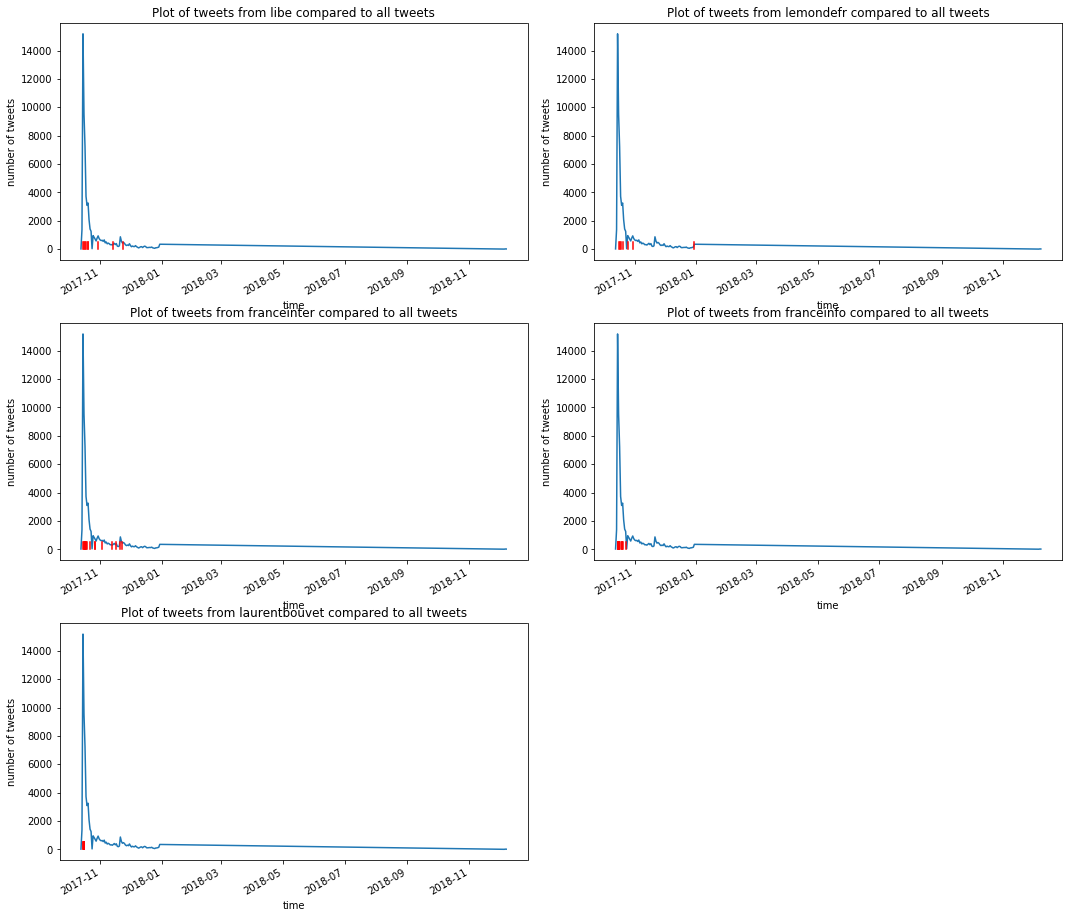

In [160]:
plot_tweets(["libe", "lemondefr", "franceinter", "franceinfo", "laurentbouvet"])

Unsuprisingly, most tweets were made during the first peak. We can notice that one tweet from lemondefr was made before the slight increase on the january 2018, and that a few twets of franceinter matches the second small peak.

### Visualizing pagerank

We know intend to visualize pagerank. For that, we will be using HoloView, a library allowing us to make interactive plot of graphs.

As the graph can be big (more than one thousand nodes), we can't plot it entirely. We need to build a subset of the graph. However, we must be carefull on how to pick our subset. We can't just create the subgraph induced by the one hundred nodes with the highest pagerank rank as the pagerank rank spread some informations along the edges. More concretely, we can have a node a connected to b connected to c, and b with a low pagerank rank, but a and c with a high one.

What we are doing, is instead to pick the ten nodes with the highest pagerank rank and plot a subgraph where these ten nodes are connected together. To ensure this property, we will also take the neightbors of these ten nodes. If the ten nodes are not included in the neighbors, we also pick the neighbors of the neighbors... We repeat the process until the selected nodes includes the ten starting nodes.

In [35]:
toselect = set(indices[:10])

In [37]:
print([graph.vs['name'][i] for i in toselect])

['Le_Figaro', 'franceinfo', 'libe', 'brutofficiel', 'Brevesdepresse', 'leLab_E1', 'le_Parisien', 'lemondefr', 'BFMTV', 'Limportant_fr']


In [11]:
def adjacent_vertices(graph, l):
    """ Get the set of neighbors of nodes in [l]"""
    neighbors = []
    for x in l:
        neighbors += graph.neighbors(x)
    return set(neighbors)

# we start by selecting all the neighbors of toselect
selected = adjacent_vertices(graph, toselect)
# Then, we select the neighbors of the selected nodes 
# until they include our starting nodes
while not (toselect <= selected):
    selected = adjacent_vertices(graph, selected)

Now that we have the node of our subgraph, we can build the subgraph.

In [12]:
graph_plot = graph.subgraph(selected)

We also build a list of the normalized pagerank rank of these nodes.

In [43]:
pagerank_top = [graph_plot.vs['pagerank'][i] for i in graph_plot.vs.indices]
m = max(pagerank_top)
pagerank_top = [p / m for p in pagerank_top]

The next step is to find the position of the nodes in the graph. For that we are using `networkx` and a spring layout.

In [45]:
G = nx.DiGraph()
G.add_nodes_from(graph_plot.vs.indices)
G.add_edges_from(e.tuple for e in graph_plot.es)
pos = nx.spring_layout(G, k=.001)

Then we can build two dataframes: one for the edges, one for the nodes.

In [46]:
edges_pd = pd.DataFrame()
edges_pd['start'] = pd.Series([e.source for e in graph_plot.es])
edges_pd['end'] = pd.Series([e.target for e in graph_plot.es])

In [47]:
nodes_pd = pd.DataFrame()
nodes_pd['x'] = [pos[i][0] for i in graph_plot.vs.indices]
nodes_pd['y'] = [pos[i][1] for i in graph_plot.vs.indices]
nodes_pd['index'] = graph_plot.vs.indices
nodes_pd['name'] = nodes_pd['index'].map(graph_plot.vs['name'].__getitem__)
nodes_pd['size'] = [pagerank_top[i] * 50 for i in graph_plot.vs.indices]

We now use `holoview` to plot the graph. We decided that each node will have a scale propotional to its pagerank rank, as well as a color depending on this rank. Edges are bundled together.

In [17]:
def export_bokeh_tojson(figure, file, plot_name="plot"):
    """ Export a figure to a json representation for bokeh.
    """
    plot = hv.renderer('bokeh').get_plot(figure).state
    f = open(file, 'w')
    f.write(json.dumps(bokeh.embed.json_item(plot, plot_name)))

In [48]:
%opts Nodes Graph [width=800 height=800 xaxis=None yaxis=None]
%opts Graph (node_size='size' edge_line_width=.25)

graph_vis = hv.Graph((edges_pd, hv.Nodes(nodes_pd)))
graph_vis = bundle_graph(graph_vis)
graph_vis = graph_vis.options(color_index='size', cmap='pastel2')

In [50]:
graph_vis

:Graph   [start,end]

In [51]:
export_bokeh_tojson(graph_vis, 'pagerank_btp.json')